In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib import pyplot
from pandas import Series
import statistics
from datetime import datetime as dt, date 
from dateutil import parser

In [40]:
gpudf = pd.read_csv('gpu.csv')
appdf = pd.read_csv('application_checkpoints.csv')
taskdf = pd.read_csv('task-x-y.csv')

In [41]:
app_task_df = pd.merge(taskdf, appdf, on = ['jobId','taskId'], how='left')
app_task_gpu_df = pd.merge(app_task_df, gpudf, on = ['timestamp'])

In [43]:
app_task_gpu_df.head()

,taskId,jobId,x,y,level,timestamp,hostname_x,eventName,eventType,hostname_y,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc
0,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12,2018-11-08T08:07:10.688Z,0745914f4de046078517041d70b22fe7000001,Tiling,STOP,265232c5f6814768aeefa66a7bec6ff600000Q,323617020812,GPU-f8ed40fb-e2c2-d6e2-9a66-4b6eaae14912,125.89,39,92,60
1,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12,2018-11-08T08:07:10.688Z,0745914f4de046078517041d70b22fe7000001,Tiling,STOP,0d56a730076643d585f77e00d2d8521a00000Q,325117171574,GPU-d84a1024-9381-c725-3b85-dd7143e64c35,25.91,33,0,0
2,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,START,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52
3,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Render,STOP,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52
4,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:49.863Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,TotalRender,STOP,8b6a0eebc87b4cb2b0539e81075191b900000U,323617021463,GPU-f955049b-a429-3eed-f7f1-30a072341123,136.61,49,94,55


In [45]:
app_task_gpu_df.shape

(337690, 16)

In [47]:
app_task_gpu_df = app_task_gpu_df.drop_duplicates(subset=None, keep='first', inplace=False)# deleting duplicate rows...

In [48]:
app_task_gpu_df.shape

(336488, 16)

In [53]:
app_task_gpu_df["time"] = app_task_gpu_df["timestamp"].apply(lambda x: parser.isoparse(x)) # extracting only time part of the timestamp column and storing it in "time" column...

/var/folders/t_/yqp01jbs4hqd74l2lcbjvbb80000gn/T/ipykernel_68421/930291541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_task_gpu_df["time"] = app_task_gpu_df["timestamp"].apply(lambda x: parser.isoparse(x)) # extracting only time part of the timestamp column and storing it in "time" column...


In [50]:
app_task_gpu_df.head()

,taskId,jobId,x,y,level,timestamp,hostname_x,eventName,eventType,hostname_y,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,time
0,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12,2018-11-08T08:07:10.688Z,0745914f4de046078517041d70b22fe7000001,Tiling,STOP,265232c5f6814768aeefa66a7bec6ff600000Q,323617020812,GPU-f8ed40fb-e2c2-d6e2-9a66-4b6eaae14912,125.89,39,92,60,2018-11-08 08:07:10.688000+00:00
1,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12,2018-11-08T08:07:10.688Z,0745914f4de046078517041d70b22fe7000001,Tiling,STOP,0d56a730076643d585f77e00d2d8521a00000Q,325117171574,GPU-d84a1024-9381-c725-3b85-dd7143e64c35,25.91,33,0,0,2018-11-08 08:07:10.688000+00:00
2,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,START,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52,2018-11-08 08:14:48.855000+00:00
3,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Render,STOP,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52,2018-11-08 08:14:48.855000+00:00
4,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:49.863Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,TotalRender,STOP,8b6a0eebc87b4cb2b0539e81075191b900000U,323617021463,GPU-f955049b-a429-3eed-f7f1-30a072341123,136.61,49,94,55,2018-11-08 08:14:49.863000+00:00


In [52]:
df_start = app_task_gpu_df[app_task_gpu_df['eventType'] == 'START']
df_stop = app_task_gpu_df[app_task_gpu_df['eventType'] == 'STOP']

df_start = df_start.rename(columns={"timestamp": "start_time"})
df_stop = df_stop.rename(columns={"timestamp": "stop_time"})

df_start = df_start.drop('eventType', axis = 1)
df_stop = df_stop.drop('eventType', axis = 1)

# convert columns to datetime
df_start["start_time"] = pd.to_datetime(df_start["start_time"])
df_stop["stop_time"] = pd.to_datetime(df_stop["stop_time"])

df = pd.merge(df_start, df_stop, on=['eventName', 'x', 'y', 'level'])

# calculate duration
df['duration'] = (df['stop_time'] - df['start_time']).dt.total_seconds()
df

,taskId_x,jobId_x,x,y,level,start_time,hostname_x_x,eventName,hostname_y_x,gpuSerial_x,...,hostname_x_y,hostname_y_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,time_y,duration
0,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08 08:14:48.855000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,d8241877cd994572b46c861e5d144c8500000W,323617021323,...,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,8b6a0eebc87b4cb2b0539e81075191b900000U,323617021463,GPU-f955049b-a429-3eed-f7f1-30a072341123,136.61,49,94,55,2018-11-08 08:14:49.863000+00:00,1.008
1,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08 07:49:17.082000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,0745914f4de046078517041d70b22fe7000014,325117064385,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
2,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08 07:49:17.082000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,8b6a0eebc87b4cb2b0539e81075191b900000T,323617021011,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
3,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08 07:49:17.082000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,265232c5f6814768aeefa66a7bec6ff600000T,323617020801,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
4,000d1def-1478-40d3-a5e3-4f848daee474,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,179,226,12,2018-11-08 08:21:27.481000+00:00,b9a1fa7ae2f74eb68f25f607980f97d700000V,Tiling,b9a1fa7ae2f74eb68f25f607980f97d7000019,324917052134,...,b9a1fa7ae2f74eb68f25f607980f97d700000V,4ad946d4435c42dabb5073531ea4f315000018,325017018095,GPU-6ab2031f-938b-3d9a-fc14-9c9e308d2716,118.93,40,91,46,2018-11-08 08:21:28.583000+00:00,1.102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85800,ecb08d02-79b5-43ef-b58c-b55b4b84e39c,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,12,4,8,2018-11-08 07:42:39.161000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700000J,Uploading,8b6a0eebc87b4cb2b0539e81075191b900001D,323617021151,...,83ea61ac1ef54f27a3bf7bd0f41ecaa700000J,265232c5f6814768aeefa66a7bec6ff6000010,323617020951,GPU-af3d11cb-8a8c-1d21-2906-216f0a3e55ad,34.37,34,1,0,2018-11-08 07:42:40.187000+00:00,1.026
85801,f7b53cc0-d2f1-421b-a7a1-4949ddc38075,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,2,6,8,2018-11-08 07:42:50.906000+00:00,cd44f5819eba427a816e7ce648adceb2000001,Uploading,265232c5f6814768aeefa66a7bec6ff6000001,323217056104,...,cd44f5819eba427a816e7ce648adceb2000001,a77ef58b13ad4c01b769dac8409af3f800000X,323617020586,GPU-9c0266e2-aa48-361b-455e-f5fc6159ee31,83.40,35,82,34,2018-11-08 07:42:51.970000+00:00,1.064
85802,f8559617-7298-4ee0-9742-9e9e7b5f54df,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,14,3,8,2018-11-08 07:43:14.194000+00:00,0d56a730076643d585f77e00d2d8521a00000R,Tiling,6139a35676de44d6b61ec247f0ed8657000018,325017018337,...,0d56a730076643d585f77e00d2d8521a00000R,83ea61ac1ef54f27a3bf7bd0f41ecaa700000X,323617043082,GPU-88356e9f-7159-3ed6-b131-c4bfc506e7e9,94.95,43,89,44,2018-11-08 07:43:15.317000+00:00,1.123
85803,fb9f46a2-a940-4773-996f-6db2204350d2,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,0,0,8,2018-11-08 07:42:13.045000+00:00,04dc4e9647154250beeee51b866b071500000X,Uploading,04dc4e9647154250beeee51b866b071500000T,323217056004,...,04dc4e9647154250beeee51b866b071500000X,b9a1fa7ae2f74eb68f25f607980f97d700001A,325017017862,GPU-7788192a-b813

In [56]:
df.head()

,taskId_x,jobId_x,x,y,level,start_time,hostname_x_x,eventName,hostname_y_x,gpuSerial_x,...,hostname_x_y,hostname_y_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,time_y,duration
0,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08 08:14:48.855000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,d8241877cd994572b46c861e5d144c8500000W,323617021323,...,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,8b6a0eebc87b4cb2b0539e81075191b900000U,323617021463,GPU-f955049b-a429-3eed-f7f1-30a072341123,136.61,49,94,55,2018-11-08 08:14:49.863000+00:00,1.008
1,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08 07:49:17.082000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,0745914f4de046078517041d70b22fe7000014,325117064385,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
2,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08 07:49:17.082000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,8b6a0eebc87b4cb2b0539e81075191b900000T,323617021011,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
3,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08 07:49:17.082000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,265232c5f6814768aeefa66a7bec6ff600000T,323617020801,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
4,000d1def-1478-40d3-a5e3-4f848daee474,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,179,226,12,2018-11-08 08:21:27.481000+00:00,b9a1fa7ae2f74eb68f25f607980f97d700000V,Tiling,b9a1fa7ae2f74eb68f25f607980f97d7000019,324917052134,...,b9a1fa7ae2f74eb68f25f607980f97d700000V,4ad946d4435c42dabb5073531ea4f315000018,325017018095,GPU-6ab2031f-938b-3d9a-fc14-9c9e308d2716,118.93,40,91,46,2018-11-08 08:21:28.583000+00:00,1.102


In [24]:
#Munging over
## Answer the questions

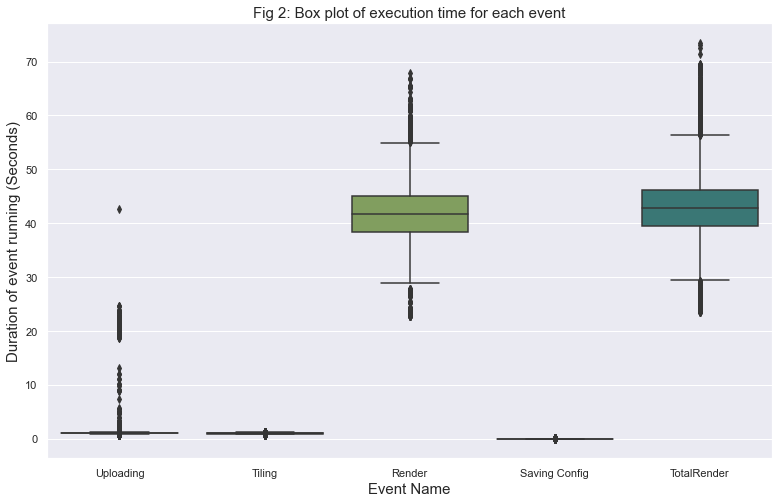

In [95]:
#ques 1

# Box plot for Events to analyse which event is taking most of the computation time...
fig, ax = plt.subplots(figsize=(13, 8))
sns.boxplot(x="eventName", y="duration", data=df, ax=ax)
sns.set(font_scale = 1.1)
sns.set_theme(style="darkgrid", palette = 'gist_earth_r')
ax.set_xlabel('Event Name', fontsize = 15)
ax.set_ylabel('Duration of event running (Seconds)', fontsize = 15)
ax.set_title("Fig 2: Box plot of execution time for each event", fontsize = 15)
plt.show()

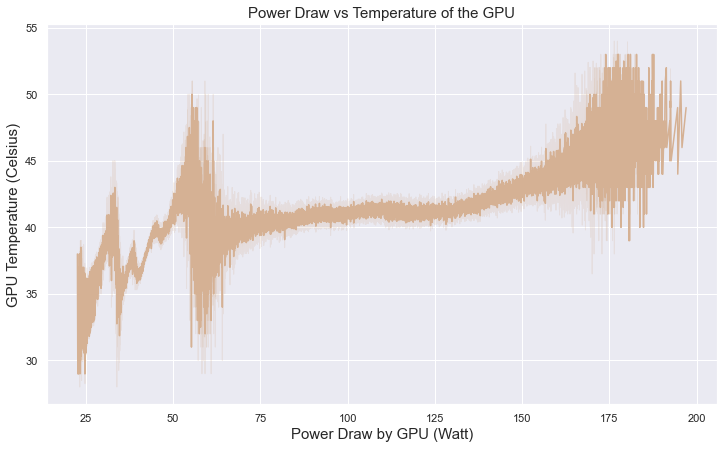

In [96]:
#ques 2



# Line plot to show relation between power draw (performance) and GPU temperature...
fig, ax = plt.subplots(figsize=(12, 7)) 
ax = sns.lineplot(data=gpudf, x="powerDrawWatt", y="gpuTempC")
plt.xlabel('Power Draw by GPU (Watt)', fontsize = 15)
plt.ylabel('GPU Temperature (Celsius)', fontsize = 15)
plt.title("Power Draw vs Temperature of the GPU", fontsize = 15)
plt.show()


In [28]:
#mazze ke liye for abstract

render_data = app_task_gpu_df[app_task_gpu_df['eventName'] != 'TotalRender']
avg_data = render_data[['gpuSerial', 'eventName', 'gpuTempC', 'gpuUtilPerc', 'gpuMemUtilPerc', 'powerDrawWatt', 'duration']].groupby(['gpuSerial','eventName']).mean()
avg_data.reset_index(inplace=True)


NameError: name 'merged_data' is not defined

In [29]:


# Pairplot of averaged data to see relationship between various GPU conditions.
sns.set(font_scale = 2)
f = sns.pairplot(avg_data, hue="eventName", diag_kind='hist',
                 diag_kws=dict(bins=20, edgecolor="k", linewidth=1),
                 plot_kws=dict(s=100, alpha=0.7, edgecolor="k"),
                 markers=["o", "s", "D"])
f.fig.suptitle("Fig 1: Pair Plot of GPU Conditions", fontsize = 20, y=1.01)
f.map_diag(plt.axhline, y=0, lw=2, color='k')
plt.show()

NameError: name 'avg_data' is not defined

NameError: name 'merged_data' is not defined

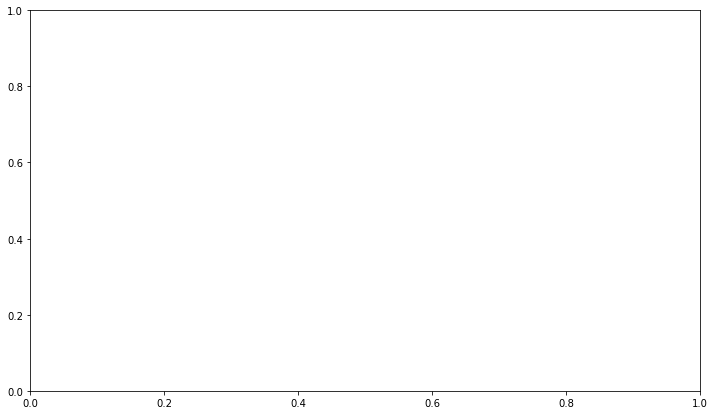

In [30]:
#ques 3



# line plot of render time against power draw...
fig, ax = plt.subplots(figsize=(12, 7)) # Figure size...
ax = sns.lineplot(data=merged_data.query("eventName == 'TotalRender'"), x="powerDrawWatt", y="duration")
plt.xlabel('Power Draw by GPU in Watt', fontsize = 15)
plt.ylabel('Render Time', fontsize = 15)
plt.title("Fig 6: Render Time based on Power Draw", fontsize = 15)
plt.show()



In [31]:
#ques 4

gpu['gpuSerial'] = gpu['gpuSerial'].astype(str) # Coverting gpuSerial to string from int...

# making a new dataframe with only gpuSerial and powerDrawWatt... 
# and finding the mean of powerDrawWatt by grouping on gpuSerial...
gpu_powerdraw = gpu[['gpuSerial', 'powerDrawWatt']].groupby(['gpuSerial']).mean() 

gpu_powerdraw.index.names = ['gpuSerial'] # Changing index of dataframe to column...
gpu_powerdraw.reset_index(inplace=True) # Resetting the index of the dataframe...


NameError: name 'gpu' is not defined

NameError: name 'gpu_powerdraw' is not defined

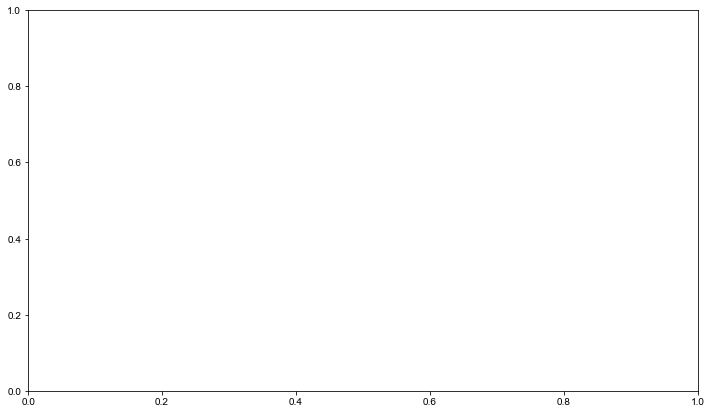

In [32]:


# line plot of power draw against serial number of the gpu...
fig, ax = plt.subplots(figsize=(12, 7)) # Figure size...
sns.set_style("darkgrid")
s = sns.lineplot(data = gpu_powerdraw, x="gpuSerial", y="powerDrawWatt")
plt.xlabel('GPU Serial Number', fontsize = 15)
plt.ylabel('Power Draw by GPU in Watt', fontsize = 15)
plt.title("Fig 5: Power Drawn by 1024 GPUs", fontsize = 15)
s.set(xticklabels=[]) # hiding overlapped x labels (gpuSerial)
plt.show()



In [33]:
# gpu tables


gpu_powerdraw = gpu_powerdraw.sort_values(by = 'powerDrawWatt') # Sorting by powerDrawWatt...
print("Low Performing GPUs")
gpu_powerdraw.head()


NameError: name 'gpu_powerdraw' is not defined

In [34]:


print("High Performing GPUs")
gpu_powerdraw.tail()



High Performing GPUs


NameError: name 'gpu_powerdraw' is not defined

In [35]:
#plot a graph from above tables

In [36]:
# reflection


In [ ]:
#conclusion